In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import os
import json

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import scipy.stats as stats
from scipy import stats
from scipy.special import inv_boxcox

from src.ForecastModel.data.models import DataModelCV
from src.ForecastModel.utils.postprocessing import ModelHandler


plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 8,
})

In [2]:
#plt.rcParams.update({
 #       'font.family' : 'Times New Roman',
  #      'axes.titlesize' : 22,
   #     'axes.labelsize' : 22,
    #    'xtick.labelsize' : 20,
     #   'ytick.labelsize' : 20})

#labelsize = 22
#legendsize = 20
#test_size = 22
#titlesize = 24
#textsize = 18

In [3]:


def bootstrap_acf_random(series, n_lags, n_bootstrap=10000, sample_size = 1000):
    acf_vals = []
    pacf_vals = []
    
    lower_acf_all = []
    higher_acf_all = []
    lower_pacf_all = []
    higher_pacf_all = []
    
    chunk_size = 10000
    chuncks = [series[i:i + chunk_size] for i in range(0, len(series), chunk_size)]
    print(len(chuncks[0]))
    
    for _ in range(n_bootstrap):
        random_int = np.random.randint(1,len(series)-sample_size)
        resampled_series = series[random_int:random_int+sample_size]
        acf_values, conf_acf = acf(resampled_series, nlags=n_lags, fft=True, alpha = 0.05)
        pacf_values, conf_pacf = pacf(resampled_series, nlags=n_lags, alpha = 0.05)
        
        lower_acf = conf_acf[:,0] - acf_values
        higher_acf = conf_acf[:,1] - acf_values
        
        lower_pacf = conf_pacf[:,0] - pacf_values
        higher_pacf = conf_pacf[:,1] - pacf_values
        
        acf_vals.append(acf_values)
        pacf_vals.append(pacf_values)
        lower_acf_all.append(lower_acf)
        higher_acf_all.append(higher_acf)
        lower_pacf_all.append(lower_pacf)
        higher_pacf_all.append(higher_pacf)        
        

    acf_vals = np.array(acf_vals)
    pacf_vals = np.asarray(pacf_vals)
    lower_acf_all = np.asarray(lower_acf_all)
    higher_acf_all = np.asarray(higher_acf_all)
    lower_pacf_all = np.asarray(lower_pacf_all)
    higher_pacf_all = np.asarray(higher_pacf_all)

    stacked_array = np.stack(acf_vals)
    acf_vals = np.mean(stacked_array, axis=0)
    stacked_array = np.stack(pacf_vals)
    pacf_vals = np.mean(stacked_array, axis=0)    

    stacked_array = np.stack(lower_acf_all)
    lower_acf_all = np.mean(stacked_array, axis=0)
    stacked_array = np.stack(higher_acf_all)
    higher_acf_all = np.mean(stacked_array, axis=0)

    stacked_array = np.stack(lower_pacf_all)
    lower_pacf_all = np.mean(stacked_array, axis=0)
    stacked_array = np.stack(higher_pacf_all)
    higher_pacf_all = np.mean(stacked_array, axis=0)   

    return acf_vals, pacf_vals, lower_acf_all, higher_acf_all, lower_pacf_all, higher_pacf_all

def bootstrap_acf(series, n_lags, n_bootstrap=10000, sample_size = 1000):
    acf_vals = []
    pacf_vals = []
    
    lower_acf_all = []
    higher_acf_all = []
    lower_pacf_all = []
    higher_pacf_all = []
    
    chuncks = [series[i:i + sample_size] for i in range(0, len(series), sample_size)]
    
    for chunck in chuncks:
        acf_values, conf_acf = acf(chunck, nlags=n_lags, fft=True, alpha = 0.05)
        pacf_values, conf_pacf = pacf(chunck, nlags=n_lags, alpha = 0.05)
        
        lower_acf = conf_acf[:,0] - acf_values
        higher_acf = conf_acf[:,1] - acf_values
        
        lower_pacf = conf_pacf[:,0] - pacf_values
        higher_pacf = conf_pacf[:,1] - pacf_values
        
        acf_vals.append(acf_values)
        pacf_vals.append(pacf_values)
        lower_acf_all.append(lower_acf)
        higher_acf_all.append(higher_acf)
        lower_pacf_all.append(lower_pacf)
        higher_pacf_all.append(higher_pacf)        
        
    acf_vals = np.array(acf_vals)
    pacf_vals = np.asarray(pacf_vals)
    lower_acf_all = np.asarray(lower_acf_all)
    higher_acf_all = np.asarray(higher_acf_all)
    lower_pacf_all = np.asarray(lower_pacf_all)
    higher_pacf_all = np.asarray(higher_pacf_all)

    stacked_array = np.stack(acf_vals)
    acf_vals = np.mean(stacked_array, axis=0)
    stacked_array = np.stack(pacf_vals)
    pacf_vals = np.mean(stacked_array, axis=0)    

    stacked_array = np.stack(lower_acf_all)
    lower_acf_all = np.mean(stacked_array, axis=0)
    stacked_array = np.stack(higher_acf_all)
    higher_acf_all = np.mean(stacked_array, axis=0)

    stacked_array = np.stack(lower_pacf_all)
    lower_pacf_all = np.mean(stacked_array, axis=0)
    stacked_array = np.stack(higher_pacf_all)
    higher_pacf_all = np.mean(stacked_array, axis=0)   

    return acf_vals, pacf_vals, lower_acf_all, higher_acf_all, lower_pacf_all, higher_pacf_all

In [4]:
PLOT_PATH          = r"plots"
DATA_PATH          = r"src\data\Dataset.csv"
CROSS_INDICES_PATH = r"src\data\indices"

In [5]:
models = {
    "arima": ModelHandler("ARIMA",
                r"rst\ARIMA",
                is_final_model = True,
                is_external_model = True,
                color = "black",
                ls = "--",
                  ),
     "elstm": ModelHandler("eLSTM",
                   r"rst\eLSTM",
                   is_final_model = True,
                   color = '#984ea3',
                   ls = "-",
                 ),
     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
              r"rst\PBHM-HLSTM",
               is_final_model = True,
               color = "#e41a1c",
              ls = "-",
              )
     }

In [61]:
n_lags = 96

df = pd.DataFrame(columns = ["acf", "pacf", "lower_acf", "higher_acf", "lower_pacf", "higher_pacf"],
              index=pd.MultiIndex(levels=[[],[],[]],codes=[[],[],[]], names=["model", "lead_time", "lag"]))

for n, key in enumerate(models.keys()):
    print(key)

    if models[key].is_external_model:
        overlap_length = 0
        hindcast_length = 96
    else:
        # load datamodel
        dm = DataModelCV(DATA_PATH,
           target_name       = models[key].target_name,
           hincast_features  = models[key].feat_hindcast,
           forecast_features = models[key].feat_forecast,
         )
        
        # load trial data
        with open(os.path.join(models[key].hp_path, "trial.json")) as f:
            trial = json.load(f)

        hindcast_length = trial['hyperparameters']['values']['hindcast_length']
        try:
            overlap_length = trial['hyperparameters']['values']['osc_length']
        except:
            overlap_length = 0 
        
        dm.main(os.path.join(CROSS_INDICES_PATH, f"cross_indices_{hindcast_length}.pkl"))

    res = np.ndarray(shape=(0,96))
    for n_fold in range(5):
        year = 2013 + n_fold
        print(year)
        if models[key].is_external_model:
            # load external which come already with observations
            ext_df = pd.read_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl"))

            # get external model observations
            y = np.expand_dims(ext_df.filter(like="obs").values, axis=2) # fix 

            # get external model predictions
            yp = ext_df.filter(like="fc").values
                        
        else:
            # load dataset
            X, y  = dm.getDataSet(dm.cross_sets[n_fold]["test"], scale=True) 

           # if os.path.exists(os.path.join(models[key].hp_path, f"forecast_{year}.pkl")):
              #  yp = pd.read_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl")).values
           # else:
            # load model
            tf.keras.backend.clear_session()
            model  = tf.keras.models.load_model(os.path.join(models[key].hp_path, f"model_fold_{n_fold:d}.keras"))                          

            # model prediction
            yp = model.predict(X, batch_size=1000)

        # check for normal distribution 
        res = np.append(res, yp-y[:,:,0], axis=0)

    #df_diff = df.copy()
    n_samples = res.shape[0]
    n_random_samples = 5000
    n_repeat = 100
    for m in range(96):
        print(m, end="\r")
        rst = [0,0,0,0,0,0]
        for repeat in range(n_repeat):
            random_idx= np.random.randint(0,n_samples - n_random_samples)
            residuals = res[random_idx:random_idx+n_random_samples, m]
            rst_new   = list(bootstrap_acf(residuals, n_lags=n_lags, sample_size = n_random_samples))
            rst = [(x/n_repeat)+y for x,y in zip(rst_new, rst)]

        for k in range(n_lags+1):
            df.loc[(key, m, k), df.columns] = [x[k] for x in rst]
          

arima
2013
2014
2015
2016
2017
elstm
dictonary loaded
2013
35/35 [==============================] - 1s 10ms/step
2014
35/35 [==============================] - 1s 5ms/step
2015
35/35 [==============================] - 1s 5ms/step
2016
35/35 [==============================] - 1s 5ms/step
2017
35/35 [==============================] - 1s 10ms/step
pbhm-hlstm
dictonary loaded
2013
35/35 [==============================] - 1s 11ms/step
2014
35/35 [==============================] - 1s 5ms/step
2015
35/35 [==============================] - 1s 10ms/step
2016
35/35 [==============================] - 1s 5ms/step
2017
35/35 [==============================] - 1s 5ms/step


In [21]:
df.to_pickle("rst/acf_pacf.pkl")

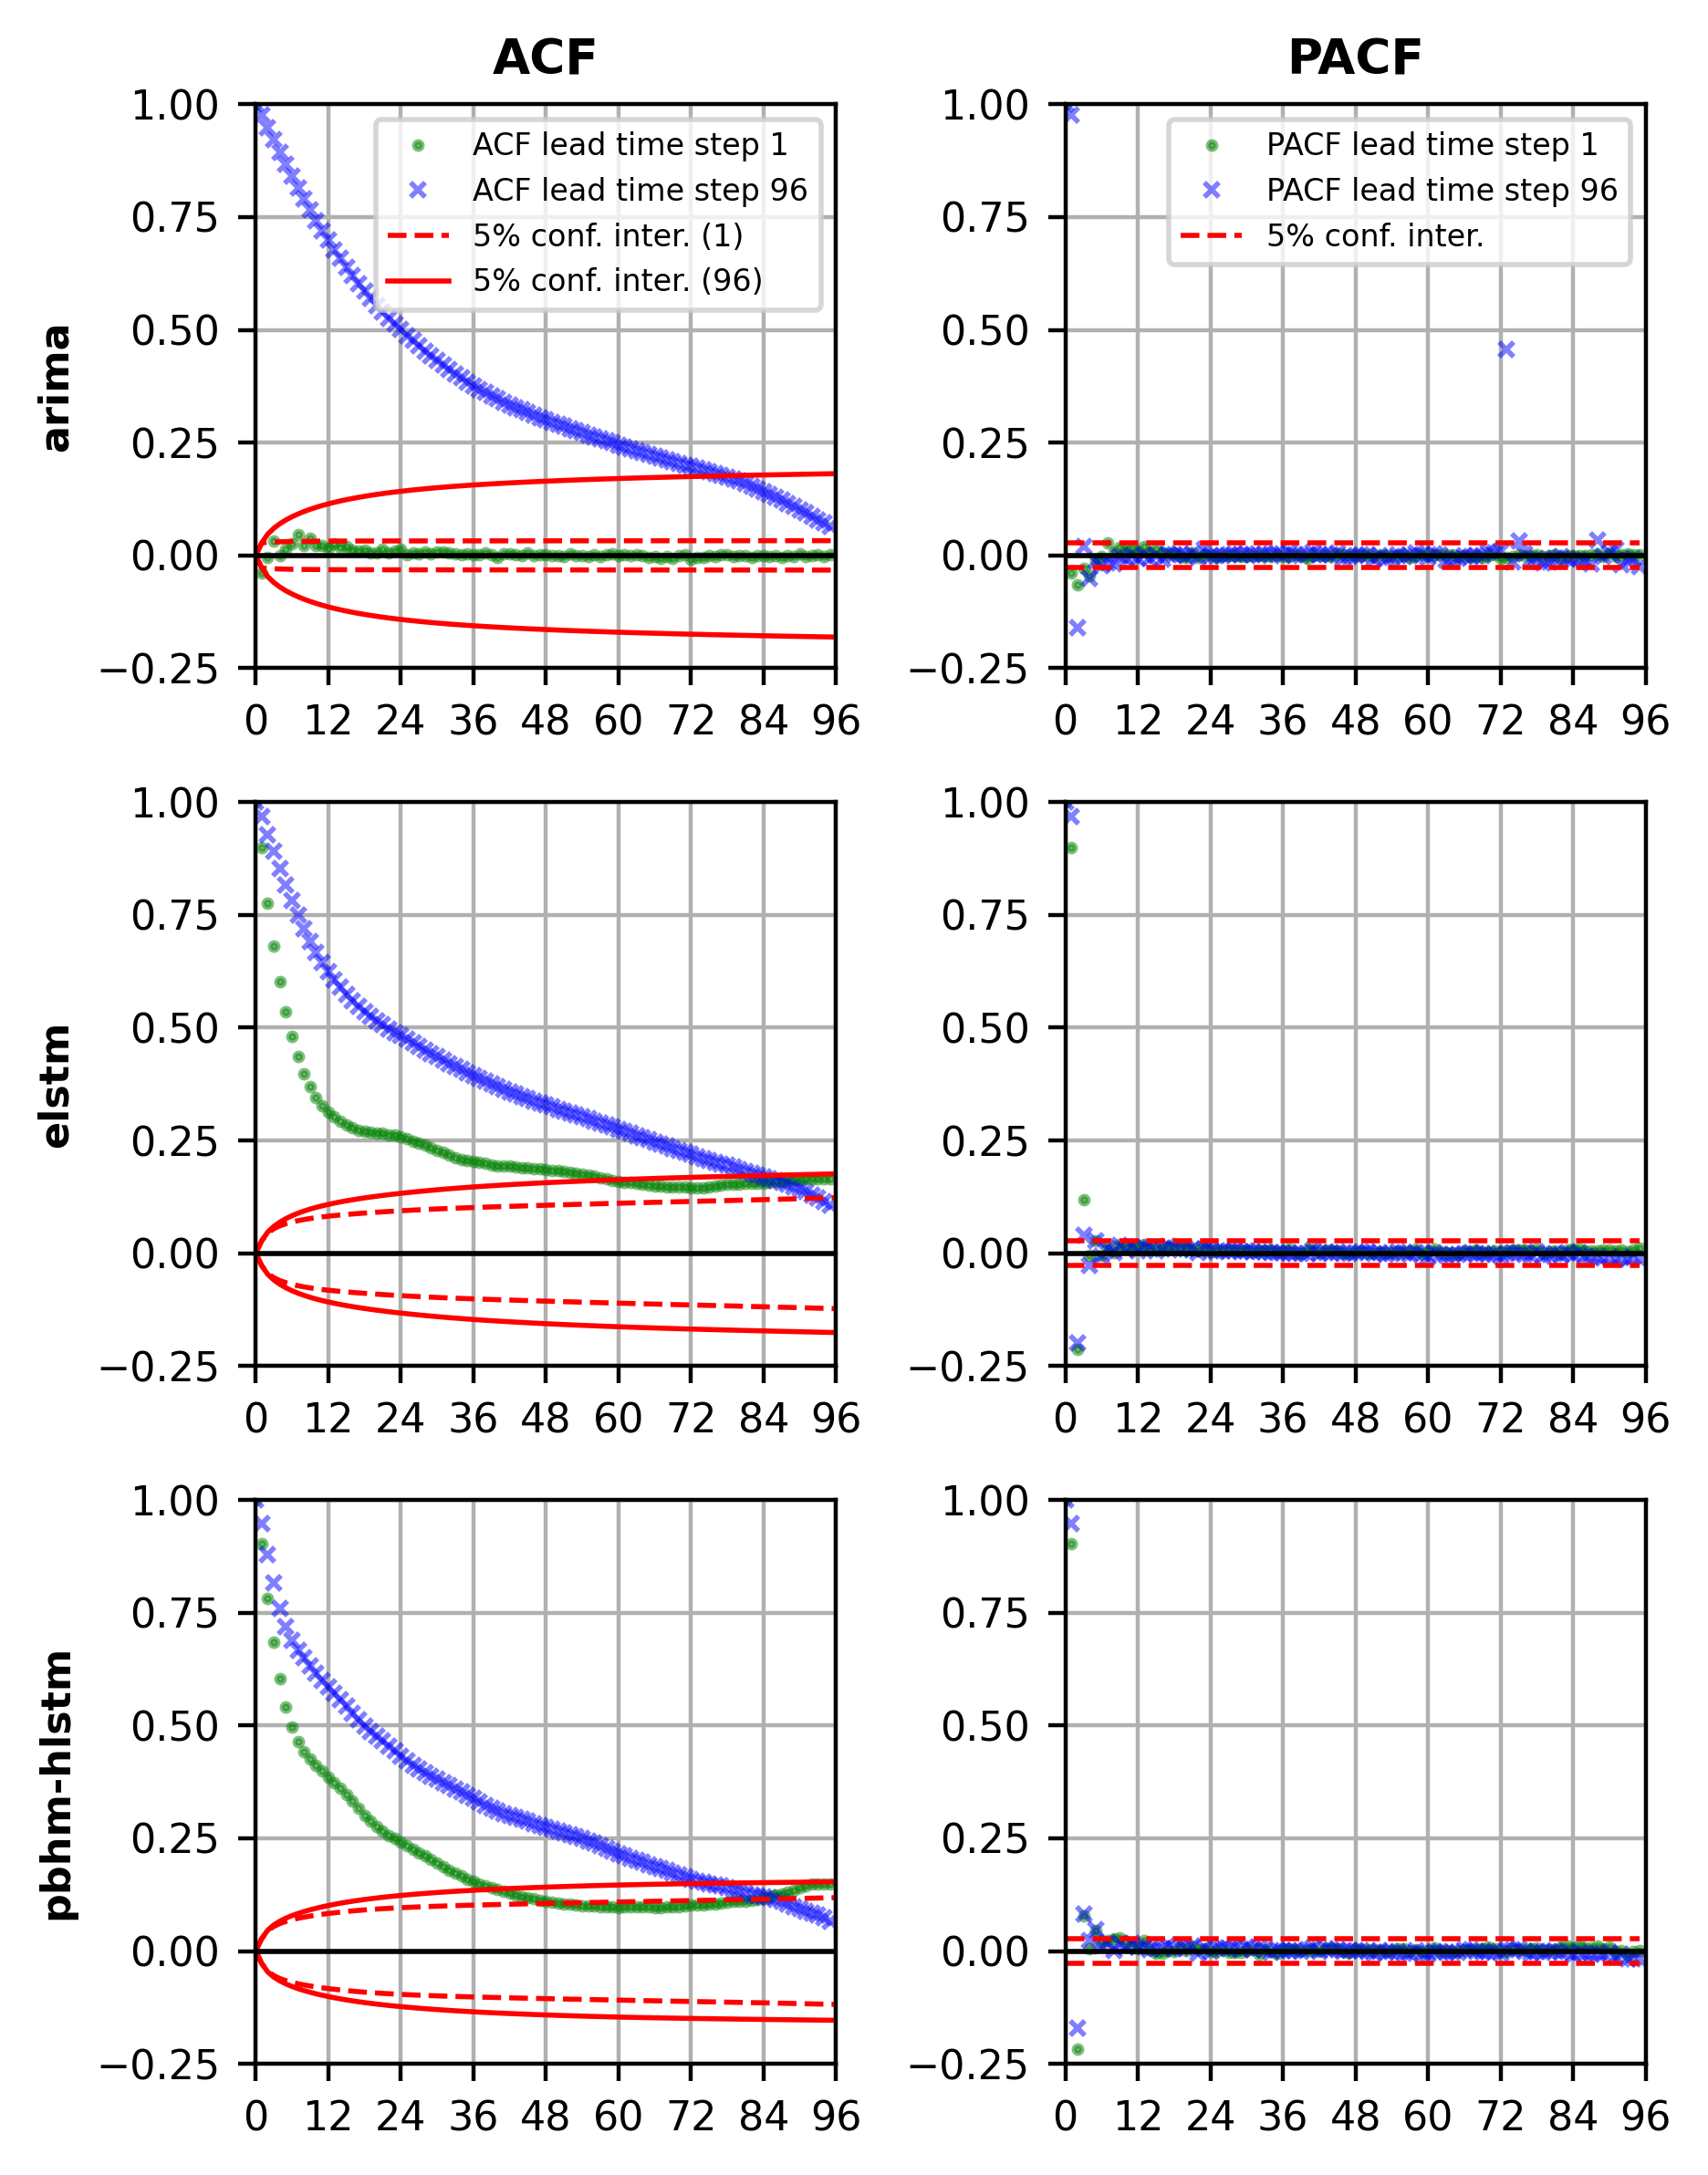

In [62]:
 #df_diff.loc[(m, k), df.columns] = [x[k] for x in rst_diff]


fig, axes = plt.subplots(3,2,figsize=(4.72,6), dpi=400)
for n, key in enumerate(models.keys()):
    for m in range(n_lags):
        print(m, end="\r")
        axes[n,0].plot(m, 
                       df.acf.xs(m, level=2).xs(key, level=0).values[0],  
                       marker=".", color="g", ls="None", 
                       markersize=3, alpha=0.5,
                       label="ACF lead time step 1" if m == 0 else "",
                      )
        axes[n,0].plot(m, 
                       df.acf.xs(m, level=2).xs(key, level=0).values[95], 
                       marker="x", color="b", ls="None", 
                       markersize=3, alpha=0.5,
                       label="ACF lead time step 96" if m == 0 else "",
                      )
      #  axes[n,0].bar(m, 
                  #     df.acf.xs(m, level=2).xs(key, level=0).values[95], 
                #       width=1, color="b", alpha=0.5,
                  #     label="ACF lead time step 96" if m == 0 else "",
                  #    )
     #   axes[n,0].bar(m, 
                  #     df.acf.xs(m, level=2).xs(key, level=0).values[0],  
                   #    width=1, color="g", alpha=0.5,
                   #    label="ACF lead time step 1" if m == 0 else "",
                  #    )
       # arrow_base   = df.acf.xs(m, level=2).xs(key, level=0).values[0]
       # arrow_length = df.acf.xs(m, level=2).xs(key, level=0).values[95] - arrow_base
       # if np.abs(arrow_length) > 0.05:
           # arrow_0 = axes[n,0].arrow(m, arrow_base, 0, arrow_length, color="g", length_includes_head=True, width=0.025, head_length=0.05, head_width=0.5)

        
        axes[n,1].plot(m, 
                       df.pacf.xs(m, level=2).xs(key, level=0).values[0],  
                       marker=".", color="g", ls="None", 
                       markersize=3, alpha=0.5,
                       label="PACF lead time step 1" if m == 0 else "",
                      )
        axes[n,1].plot(m, 
                       df.pacf.xs(m, level=2).xs(key, level=0).values[95], 
                       marker="x", color="b", ls="None", 
                       markersize=3, alpha=0.5,
                       label="PACF lead time step 96" if m == 0 else "",
                      )
        #arrow_base   = df.pacf.xs(m, level=2).xs(key, level=0).values[0]
       # arrow_length = df.pacf.xs(m, level=2).xs(key, level=0).values[95] - arrow_base
       # if np.abs(arrow_length) > 0.05:
          #  axes[n,1].arrow(m, arrow_base, 0, arrow_length, color="g", length_includes_head=True, width=0.025, head_length=0.07, head_width=0.5)
        
       # axes[n,0].plot(m+1, df_diff.acf.xs(m, level=1).values[0],  marker=".", color="b", ls="None", markersize=3)
        #axes[n,0].plot(m+1, df_diff.acf.xs(m, level=1).values[95], marker="x", color="b", ls="None", markersize=3)
        #arrow_base   = df_diff.acf.xs(m, level=1).values[0]
        #arrow_length = df_diff.acf.xs(m, level=1).values[95] - arrow_base
        #if np.abs(arrow_length) > 0.05:
         #   arrow_1 = axes[n,0].arrow(m+1, arrow_base, 0, arrow_length, color="b", length_includes_head=True, width=0.025, head_length=0.05, head_width=0.5)

        
        #axes[n,1].plot(m+1, df_diff.pacf.xs(m, level=1).values[0],  marker=".", color="b", ls="None", markersize=3)
        #axes[n,1].plot(m+1, df_diff.pacf.xs(m, level=1).values[95], marker="x", color="b", ls="None", markersize=3)
        #arrow_base   = df_diff.pacf.xs(m, level=1).values[0]
        #arrow_length = df_diff.pacf.xs(m, level=1).values[95] - arrow_base
        #if np.abs(arrow_length) > 0.05:
         #   axes[n,1].arrow(m+1, arrow_base, 0, arrow_length, color="b", length_includes_head=True, width=0.025, head_length=0.05, head_width=0.5)

    axes[n,0].plot(np.arange(0,n_lags+1,1), 
                   df.lower_acf.xs(0,   level=1).xs(key, level=0).values,
                   color="r", ls="--", lw=1,
                   label = r"5% conf. inter. (1)",
                  )
    axes[n,0].plot(np.arange(0,n_lags+1,1), 
                   df.lower_acf.xs(95,  level=1).xs(key, level=0).values, 
                   color="r", ls="-", lw=1,
                   label = r"5% conf. inter. (96)",
                )
    axes[n,1].plot(np.arange(0,n_lags,1), 
                   df.lower_pacf.xs(0,  level=1).xs(key, level=0).values[1:], 
                   color="r", ls="--", lw=1,
                   label = r"5% conf. inter.",
                )
    #axes[n,1].plot(np.arange(0,n_lags+1,1), df.lower_pacf.xs(95, level=1).xs(key, level=0).values, color="r", ls="-", lw=1)
    axes[n,0].plot(np.arange(0,n_lags+1,1), df.higher_acf.xs(0,  level=1).xs(key, level=0).values, color="r", ls="--", lw=1)
    axes[n,0].plot(np.arange(0,n_lags+1,1), df.higher_acf.xs(95, level=1).xs(key, level=0).values, color="r", ls="-", lw=1)
    axes[n,1].plot(np.arange(0,n_lags,1),  df.higher_pacf.xs(0, level=1).xs(key, level=0).values[1:], color="r", ls="--", lw=1)
    #axes[n,1].plot(np.arange(0,n_lags+1,1), df.higher_pacf.xs(95,level=1).xs(key, level=0).values, color="r", ls="-", lw=1)
    axes[0,0].set_title("ACF", fontweight="bold")
    axes[0,1].set_title("PACF", fontweight="bold")
    
    for m in range(2):
        axes[n,m].grid()
        axes[n,m].axhline(y = 0.0, color = 'k', lw=1)
        #axes[n,m].set_xlim((0,n_lags))
        if m == 0:
            axes[n,m].set_ylim((-0.25,1))
            #axes[n,m].text(n_lags-2, 0.9, key, ha="right", fontweight="bold")
            axes[n,m].set_ylabel(key, fontweight="bold")
        else:
            axes[n,m].set_ylim((-0.25,1))
            #axes[n,m].text(n_lags-2, 0.9, key, ha="right", fontweight="bold")
        axes[n,m].set_xticks(np.arange(0,100,12))
        axes[n,m].set_xlim((0,96))

    if n == 1:
        axes[0,0].legend(loc="upper right", prop={'size': 6})
        axes[0,1].legend(loc="upper right", prop={'size': 6})
    if n == 4:
        axes[n,m].set_xlabel("lag")
        
fig.tight_layout()
#axes[0,1].legend([arrow_0, arrow_1], ["residuals","residuals - differentiated"],
              #  bbox_to_anchor=(-0.15, 1.25), 
             #   loc='lower center', ncol=3, 
              #  borderaxespad=0)

In [63]:
fig.savefig(os.path.join(PLOT_PATH, 'ACF_PACF-leadtime-rnd2.png'), dpi=300, bbox_inches='tight')

In [18]:
df

acf      pacf lower_acf higher_acf lower_pacf  \
model      lead_time lag                                                       
arima      0         0         0.1       0.1       0.0        0.0        0.0   
                     1     0.00104   0.00104 -0.002772   0.002772  -0.002772   
                     2   -0.002014 -0.007258 -0.002902   0.002902  -0.002772   
                     3    0.000589 -0.001482 -0.002927   0.002927  -0.002772   
                     4   -0.002836 -0.005074 -0.002952   0.002952  -0.002772   
...                            ...       ...       ...        ...        ...   
pbhm-hlstm 95        92   0.013978 -0.001707 -0.016677   0.016677  -0.002772   
                     93   0.013237 -0.002302 -0.016699   0.016699  -0.002772   
                     94    0.01243 -0.001604 -0.016722   0.016722  -0.002772   
                     95   0.011517   -0.0018 -0.016744   0.016744  -0.002772   
                     96   0.010474 -0.002903 -0.016767   0.016767  -0.002772   

                         higher_pacf  
model      lead_time lag              
arima      0         0           0.0  
                     1      0.002772  
                     2      0.002772  
                     3      0.002772  
                     4      0.002772  
...                              ...  
pbhm-hlstm 95        92     0.002772  
                     93     0.002772  
                     94     0.002772  
                     95     0.002772  
                     96     0.002772  

[27936 rows x 6 columns]

In [65]:
(y[:,:,0]-yp)

array([[-0.0966894 , -0.07723301, -0.07508718, ..., -0.01860741,
        -0.0109205 , -0.00627056],
       [-0.11778444, -0.09686452, -0.09466832, ..., -0.0178161 ,
        -0.00971148, -0.01616578],
       [-0.11474412, -0.09373462, -0.09082472, ..., -0.01625827,
        -0.0194181 , -0.01643412],
       ...,
       [-0.05257529, -0.04901189, -0.05395252, ..., -0.1356944 ,
        -0.1561022 , -0.17396791],
       [-0.05363333, -0.04987413, -0.05568999, ..., -0.14507337,
        -0.16707005, -0.18492742],
       [-0.05489356, -0.05188811, -0.05755526, ..., -0.15709068,
        -0.17833068, -0.19445642]])